## Learning Outcomes
By completing this project, you will be able to implement and use randomization tests to determine whether a specific effect is statistically significant. Randomization tests are a highly universal and powerful way to do this, and form an essential part of the toolkit of any Data Scientist. 

## Problem Description
An increasingly common statistical tool for determining whether a difference is significant is the randomization or permutation test. A randomization test builds - rather than assumes – a sampling distribution of the test statistics. This is achieved by exchanging or permuting variables which are “exchangeable” under the Null-hypothesis. A randomization test gives a simple way to compute the sampling distribution for any test statistic under the null hypothesis that the dependent variable is statistically not dependent on the shuffled variable. 
In this project, we continue with the movie dataset from "Categorical Data and Probability". The main task is to determine whether the difference in proportion for female vs. male directors to direct action movies is significant. 

In [20]:
# Importing packages
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import numpy as np
import pandas as pd
import scipy.stats as stats

# Load dataset file
df = pd.read_csv("movieDataset1.csv")
df.head()

,Unnamed: 0,boxoff,prodcost,dirIncome,dirGender,year,month,genre,numTheatres
0,0,88.648583,44.742936,1.143234,male,2012,3,comedy,139
1,1,145.334924,38.835516,3.393535,female,2014,11,drama,213
2,2,238.265684,29.532283,2.418883,male,2015,6,other,100
3,3,212.714742,157.111899,2.034115,male,2014,10,adventure,436
4,4,120.175461,30.547155,0.963219,female,2012,1,comedy,115


## TASK 1: Defining the Test Statistics

In [21]:
# Create contingency table of adventure (yes/no) by director gender 
ctab = pd.crosstab(df["dirGender"], df["genre"] == "adventure", margins=1)
display(ctab)

genre,False,True,All
dirGender,,,
female,31,6,37
male,155,58,213
All,186,64,250


In [27]:
# Calculate p(adventure|female)-p(adventure|male)
# Calculate the probability that the movie is an adventure given that the director Gender is female,
adventure_f = ctab[True]["female"]/(ctab['All']["female"])
print(f"The probability that the movie is an adventure given that the director Gender is female is {adventure_f.round(6)}")

# Calculate the probability of the movie is an adventure given that the director Gender is male
adventure_m = ctab[True]["male"]/(ctab['All']["male"])
print(f"The probability that the movie is an adventure given that the director Gender is male is {adventure_m.round(6)}")

# Calculate result
diff = adventure_f - adventure_m
print(f"\np(adventure|female)-p(adventure|male) is {diff.round(6)}")
#type(diff)

The probability that the movie is an adventure given that the director Gender is female is 0.162162
The probability that the movie is an adventure given that the director Gender is male is 0.2723

p(adventure|female)-p(adventure|male) is -0.110138


In [40]:
# Define a function that calculates the difference in average income by gender
def avg_income_diff(data, genre='adventure'):
    """
    Args:
        data (pd.dataframe) - input dataset
        genre (str) - movie genre to select
        
    Returns:
        diff (float) - difference between avg incomes
    """
    dat = data[data['genre']==genre]
    #print(dat.head())
    income_by_gender = dat['dirIncome'].groupby(dat['dirGender'])
    income_m = income_by_gender.get_group('male')
    #print(income_m)
    income_f = income_by_gender.get_group('female')
    diff = income_m.mean() - income_f.mean()
    return diff

In [41]:
# Test difference function
diff = avg_income_diff(df, genre='adventure')
print(f'The average income difference is: {diff:.6f}')
diff = avg_income_diff(df, genre='action')
print(f'The average income difference is: {diff:.6f}')

The average income difference is: 0.212741
The average income difference is: 0.810571


## Task 2: Perform a Permutation Test

We want to test the hypothesis that female directors of adventure movies earn less, on average, than male directors of adventure movies. 
>The null hypothesis is that the incomes are equal (the difference zero) or that female directors earn more on average than male directors.

In [54]:
# Perform a permutation test. Under the Null-hypothesis the director gender is exchangeable. 
# Write a function that takes the data frame as an input and then randomly permutes the directorGender column.
def perm_test(data, n_iter=500, genre='adventure', var='dirGender'):
    """
    Args:
        data (pd.dataframe) - input dataset
        n_iter (int) - number of iterations
        genre (str) - movie genre to select
        var (str) - column to permute
        
    Returns:
        stat (np.ndarray) - array of test statistics
        p_val (float) - p-value of the test statistic
    """
    # Initialize stat array
    stat = np.zeros([n_iter])
    #print(stat)
        
    # Create a copy of the data
    d = data.copy()
    #display(d)
    d = d[d['genre']==genre].reset_index(drop=1)
    #display(d)
    
    # Create an array that represent the indices
    idx = np.arange(len(d.index))
    #display(idx)

    for i in range(n_iter):
        
        ## Randomly shuffle indices
        np.random.shuffle(idx)
        
        # Shuffle the selected variable
        shuff_var = d[var].iloc[idx]
        
        # Reorder the shuffled indices
        shuff_var = shuff_var.reset_index(drop=1)
        
        # Put the shuffled gender variable back in
        d[var] = shuff_var
        #display(d)
        
        # Calculate test statistic
        stat[i] = avg_income_diff(d, genre='adventure')
    
    # Plot the histogram of results
    sns.distplot(stat) 
    plt.xlabel('Distribution of differences in avg income')
    
    # Calculate and mark the value of the empirical test statistics
    diff = avg_income_diff(data, genre='adventure')
    print(f'The empirical difference in avg incomes is: {diff:.6f}')
    plt.axvline(diff, color = 'red', alpha = 1, lw = 1.5)
    
    # Calculate the p-value
    H1 = stat > diff
    N = sum(H1)
    p_val = N/len(stat)        
    
    return stat, p_val

The empirical difference in avg incomes is: 0.212741
The p-value of the test statistic is: 0.369000


/Users/oliviachoi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


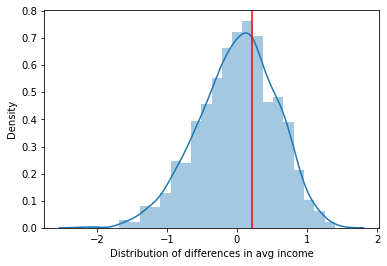

In [55]:
# Perform permutation test here
stat, p_val = perm_test(df, n_iter=1000)
print(f'The p-value of the test statistic is: {p_val:.6f}')

> Since p-value is pretty large (0.369 > 0.05), we do not reject the null hypothesis.